In [1]:
# Data processing
import numpy as np
import pandas as pd

# Visualization
import seaborn as sns

# Create synthetic data
from causalml.dataset import synthetic_data

# Machine learning model
from causalml.inference.meta import BaseSRegressor, LRSRegressor
from xgboost import XGBRegressor


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
Failed to import duecredit due to No module named 'duecredit'


In [2]:
np.random.seed(42)
# Create a synthetic dataset
y, X, treatment, ite, _, _ = synthetic_data(mode=1, n=1000, p=5, sigma=1.0)
feature_names = ["X1", "X2", "X3", "X4", "X5"]


In [3]:
# Check treatment vs. control counts
pd.Series(treatment).value_counts()

1    512
0    488
Name: count, dtype: int64

The true average treatment effect (ATE) by taking the mean of the true individual treatment effect (ITE)

In [4]:
print(ite.mean())

0.4982285515450249


### Model

* LRSRegressor is a built-in ordinary least squares (OLS) s-learner model that comes with the causalML package.
* BaseSRegressor is a generalized method that can take in existing machine learning models from pakcages such as sklearn and xgboost, and run s-learners with those models.

#### LR S regressor

In [5]:
lr = LRSRegressor()
# Estimated ATE, upper bound, and lower bound
te, lb, ub = lr.estimate_ate(X, treatment, y)
# Print out results
print("Average Treatment Effect (Linear Regression): {:.2f} ({:.2f}, {:.2f})".format(te[0], lb[0], ub[0]))


Average Treatment Effect (Linear Regression): 0.65 (0.50, 0.80)


#### Base S regressor

In [6]:
xgb = BaseSRegressor(XGBRegressor(random_state=42))
# Estimated ATE, upper bound, and lower bound
te, lb, ub = xgb.estimate_ate(X, treatment, y, return_ci=True)
# Print out results
print('Average Treatment Effect (Linear Regression): {:.2f} ({:.2f}, {:.2f})'.format(te[0], lb[0], ub[0]))

Average Treatment Effect (Linear Regression): 0.45 (0.41, 0.49)


The results show that using the BaseSRegressor in combination with XGBoost produced a much more accurate estimation for the average treatment effect (ATE).

### S-Learner Individual Treatment Effect (ITE)

In [7]:
# ITE
xgb_ite = xgb.fit_predict(X, treatment, y)
# Take a look at the data
print('\nThe first five estimated ITEs are:\n', np.matrix(xgb_ite[:5]))


The first five estimated ITEs are:
 [[-0.37826091]
 [-0.2244699 ]
 [-0.8989895 ]
 [ 0.5455873 ]
 [ 0.20486137]]


In [8]:
xgb_ite, xgb_ite_lb, xgb_ite_ub = xgb.fit_predict(
    X=X, treatment=treatment, y=y, return_ci=True, n_bootstraps=100, bootstrap_size=500
)
# Take a look at the data
print("\nThe first five estimated ITEs are:\n", np.matrix(xgb_ite[:5]))
print("\nThe first five estimated ITE lower bound are:\n", np.matrix(xgb_ite_lb[:5]))
print("\nThe first five estimated ITE upper bound are:\n", np.matrix(xgb_ite_ub[:5]))


100%|██████████| 100/100 [00:11<00:00,  8.91it/s]


The first five estimated ITEs are:
 [[-0.37826091]
 [-0.2244699 ]
 [-0.8989895 ]
 [ 0.5455873 ]
 [ 0.20486137]]

The first five estimated ITE lower bound are:
 [[-0.25444596]
 [-1.17449643]
 [-1.48374597]
 [-0.50003245]
 [-0.20262158]]

The first five estimated ITE upper bound are:
 [[1.51246799]
 [0.91703835]
 [1.1258374 ]
 [1.43301205]
 [1.61455589]]


In [9]:
# Estimate ATE
xgb_ite.mean()

0.4529251796975732

### S-Learner Model Feature Importance

In [10]:
xgb.get_importance(X=X, tau=xgb_ite, normalize=True, method="auto", features=feature_names)


{1: X1    0.273574
 X4    0.237480
 X5    0.173491
 X3    0.162954
 X2    0.152501
 dtype: float64}

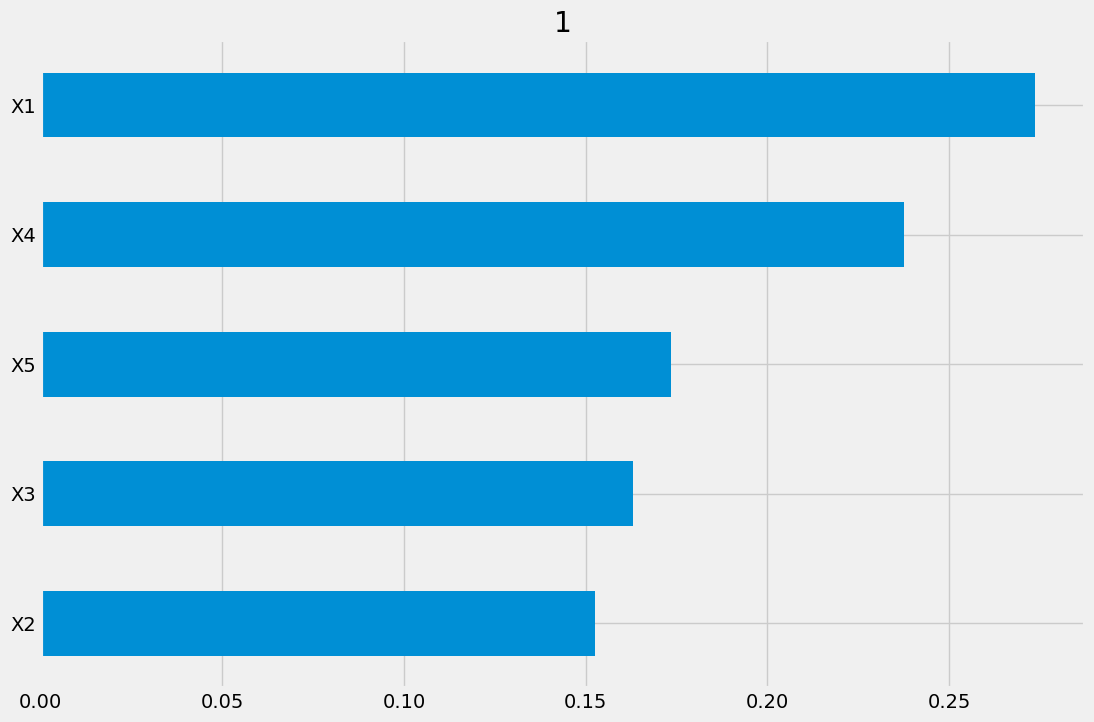

In [11]:
xgb.plot_importance(X=X, tau=xgb_ite, normalize=True, method="auto", features=feature_names)


In [12]:
xgb.get_importance(X=X, tau=xgb_ite, method="permutation", features=feature_names, random_state=42)


{1: X1    0.492460
 X4    0.482355
 X2    0.306620
 X5    0.274297
 X3    0.193741
 dtype: float64}

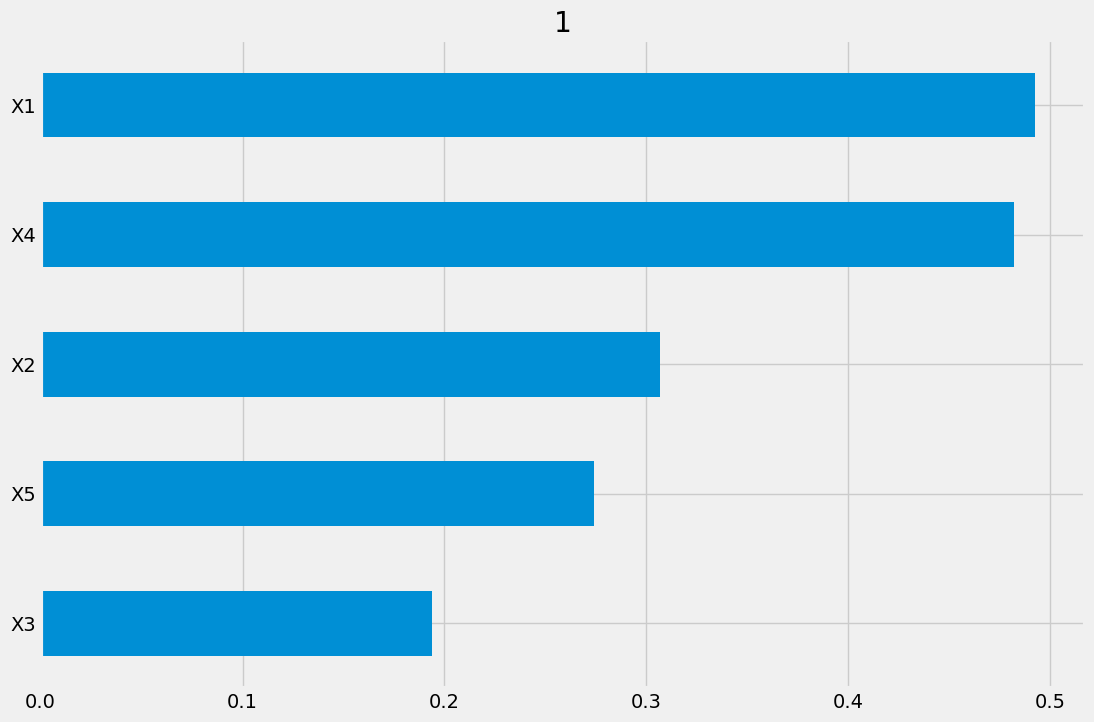

In [13]:
xgb.plot_importance(X=X, tau=xgb_ite, method="permutation", features=feature_names, random_state=42)


### S-Learner Model Interpretation

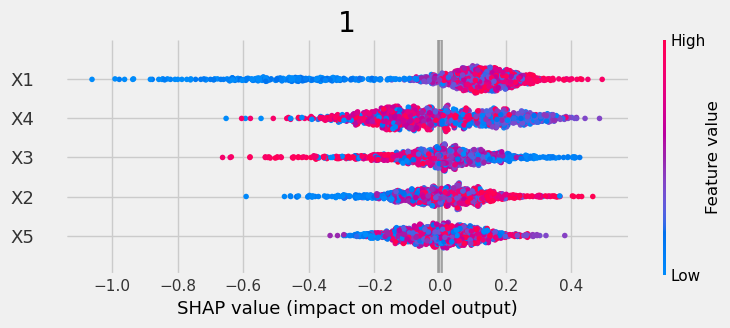

In [14]:
xgb.plot_shap_values(X=X, tau=xgb_ite, features=feature_names)

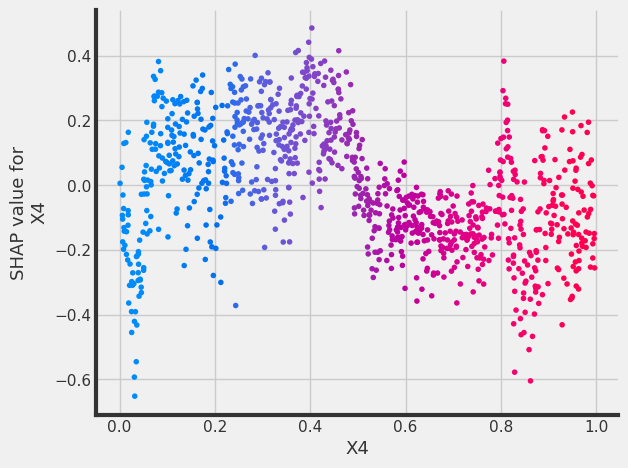

In [15]:
xgb.plot_shap_dependence(treatment_group=1, feature_idx=3, X=X, tau=xgb_ite, interaction_idx=3, features=feature_names)


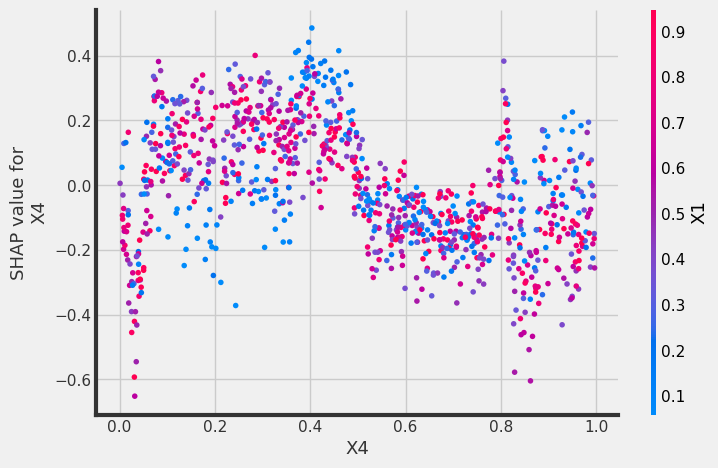

In [16]:
xgb.plot_shap_dependence(treatment_group=1,
                         feature_idx=3,
                         X=X,
                         tau=xgb_ite,
                         interaction_idx='auto',
                         features=feature_names)